# 挂载google drive拷贝数据

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/Skin_Dataset ./ -r

前面，我们实现和测试了unet网络来进行图像分割，基于这个网络结构，我们可以稍作改进，来实现一个对称的网络结构，来进行皮肤区域的分割。但在此之前，需要对我们的数据集进行扩展。

#数据扩展
这里我们有原始的皮肤分割训练图像78张，这里对每张图像扩展10倍的数据量，因为每张图像的大小不同，这里我们使用一个开源工程[imgaug](https://github.com/aleju/imgaug)来进行数据扩展。

In [0]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import os
from skimage import color
import numpy as np
from imgaug.augmentables.segmaps import SegmentationMapOnImage

def train_augment(train_path,image_dir,mask_dir,aug_multiples):
  ia.seed(10)
  seq = iaa.Sequential([iaa.Fliplr(0.5),#以50%的概率水平翻转
              iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                   translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                   rotate=(-10, 10),mode='edge')
                        ],random_order=True)
  image_list=os.listdir(os.path.join(train_path,image_dir))
  for image_file in image_list:
    file_name=os.path.splitext(image_file)[0]
    image=imageio.imread(os.path.join(train_path,image_dir,image_file))
    mask_file=file_name+'.png'
    mask=imageio.imread(os.path.join(train_path,mask_dir,mask_file))
    mask=mask[:,:,0]
    image_augs,mask_augs=seq(images=[image]*aug_multiples, segmentation_maps=[mask]*aug_multiples)
    index=1
    for image_aug,mask_aug in zip(image_augs,mask_augs):
      imageio.imwrite(os.path.join(train_path,image_dir,file_name+'_'+str(index)+'.jpg'),image_aug)
      imageio.imwrite(os.path.join(train_path,mask_dir,file_name+'_'+str(index)+'.png'),mask_aug)
      index+=1

train_augment('./Skin_Dataset','Pratheepan_Dataset','Ground_Truth',10)

#计算类别权重
因为皮肤区域和非皮肤区域占比不同，我们需要给他们赋予不同的权重来平衡。这里统计它们的像素占比，然后计算比例。

In [0]:
import numpy as np
from skimage import io
import os

mask_list=os.listdir("/content/Skin_Dataset/Ground_Truth")
skin_count=0
non_skin_count=0
for mask_file in mask_list:
  mask=io.imread(os.path.join("/content/Skin_Dataset/Ground_Truth",mask_file))
  if len(mask.shape)>2:
    mask=np.squeeze(mask[:,:,0])
  current_skin=(mask>255/2).sum()
  skin_count+=current_skin
  current_non_skin=mask.size-current_skin
  non_skin_count+=current_non_skin
print("skin:non_skin=1:",non_skin_count/skin_count)

skin:non_skin=1: 5.219962416662616


所以，这里赋予skin类权重5.219962416662616,non_skin类权重1。

# 定义网络结构
这里把unet中的非对称结构网络，换成了对称结构，然后把每层网络的channel数量减半来降低网络复杂度。
因为unet是全卷积网络，所以其实可以处理任意大小图像，但是为了让下采样和对应上采样的结果匹配，我们这里要求图像的宽高都是16的整数倍，如果不是，需要做些填充处理。

In [2]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import keras

def skin_net(pretrained_weights = None,is_train=False):
  inputs = Input(shape=(None,None,3))
  conv1=Conv2D(32,3,activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
  conv1=Conv2D(32,3,activation='relu',kernel_initializer='he_normal',padding='same')(conv1)
  pool1=MaxPooling2D(pool_size=(2,2))(conv1)
  conv2=Conv2D(64,3,activation='relu',kernel_initializer='he_normal',padding='same')(pool1)
  conv2=Conv2D(64,3,activation='relu',kernel_initializer='he_normal',padding='same')(conv2)
  pool2=MaxPooling2D(pool_size=(2,2))(conv2)
  conv3=Conv2D(128,3,activation='relu',kernel_initializer='he_normal',padding='same')(pool2)
  conv3=Conv2D(128,3,activation='relu',kernel_initializer='he_normal',padding='same')(conv3)
  pool3=MaxPooling2D(pool_size=(2,2))(conv3)
  conv4=Conv2D(256,3,activation='relu',kernel_initializer='he_normal',padding='same')(pool3)
  conv4=Conv2D(256,3,activation='relu',kernel_initializer='he_normal',padding='same')(conv4)
  pool4=MaxPooling2D(pool_size=(2,2))(conv4)
  conv5=Conv2D(512,3,activation='relu',kernel_initializer='he_normal',padding='same')(pool4)
  conv5=Conv2D(512,3,activation='relu',kernel_initializer='he_normal',padding='same')(conv5)
  up6=Conv2D(256,2,activation='relu',padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv5))
  merge6=concatenate([conv4,up6],axis=3)
  conv6=Conv2D(256,3,activation='relu',kernel_initializer='he_normal',padding = 'same')(merge6)
  conv6=Conv2D(256,3,activation='relu',kernel_initializer='he_normal',padding = 'same')(conv6)
  up7=Conv2D(128,2,activation='relu',padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
  merge7=concatenate([conv3,up7],axis=3)
  conv7=Conv2D(128,3,activation='relu',kernel_initializer='he_normal',padding = 'same')(merge7)
  conv7=Conv2D(128,3,activation='relu',kernel_initializer='he_normal',padding = 'same')(conv7)
  up8=Conv2D(64,2,activation='relu',padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
  merge8=concatenate([conv2,up8],axis=3)
  conv8=Conv2D(64,3,activation='relu',kernel_initializer='he_normal',padding = 'same')(merge8)
  conv8=Conv2D(64,3,activation='relu',kernel_initializer='he_normal',padding = 'same')(conv8)
  up9=Conv2D(32,2,activation='relu',padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
  merge9=concatenate([conv1,up9],axis=3)
  conv9=Conv2D(32,3,activation='relu',kernel_initializer='he_normal',padding = 'same')(merge9)
  conv9=Conv2D(32,3,activation='relu',kernel_initializer='he_normal',padding = 'same')(conv9)
  conv10=Conv2D(1,1,activation = 'sigmoid',kernel_initializer='he_normal')(conv9)
  model = Model(inputs = inputs, outputs = conv10)
  if is_train:
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
  if pretrained_weights:
    model.load_weights(pretrained_weights)
  return model

Using TensorFlow backend.


# 产生训练数据
这里因为每个图像的尺寸都不一样，所以固定了batch_size为1，然后将图像填充到8的倍数。

In [0]:
import os
from skimage import io
import numpy as np
import random

def train_generator(image_dir,mask_dir):
  image_list=os.listdir(image_dir)
  print(len(image_list))
  while True:
    random.shuffle(image_list)
    for image_file in image_list:
      file_name=os.path.splitext(image_file)[0]
      image=io.imread(os.path.join(image_dir,image_file))
      image=image.astype(float)/255
      #扩展宽高到8的倍数
      h_remainder=image.shape[0]%16
      w_remainder=image.shape[1]%16
      h_pad=0
      w_pad=0
      if h_remainder!=0:
        h_pad=int(16-h_remainder)
      if w_remainder!=0:
        w_pad=int(16-w_remainder)
      image=np.pad(image,((0,h_pad),(0,w_pad),(0,0)),'edge')
      image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
      mask_file=os.path.join(mask_dir,file_name+'.png')
      mask=io.imread(mask_file)
      if len(mask.shape)>2:
        mask=np.squeeze(mask[:,:,0])
      mask_true=np.zeros_like(mask)
      mask_true[mask>128]=1
      mask_true=np.pad(mask_true,((0,h_pad),(0,w_pad)),'edge')
      mask_true=mask_true.reshape((1,mask_true.shape[0],mask_true.shape[1],1))
      yield (image,mask_true)
# gen=train_generator("/content/Skin_Dataset/Pratheepan_Dataset","/content/Skin_Dataset/Ground_Truth")
# for image,mask in gen:
#   print(np.max(mask),np.min(mask))

In [0]:
!ls -l /content/Skin_Dataset/Ground_Truth/family.png

-rw-rw-rw- 1 root root 1311570 Oct 12 01:18 /content/Skin_Dataset/Ground_Truth/family.png


#训练网络


In [27]:
from keras.callbacks import ModelCheckpoint
import keras.backend as K

K.clear_session()
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/skin_net.hdf5', monitor='loss',verbose=1, save_best_only=True,save_weights_only=True)
data_gen=train_generator("/content/Skin_Dataset/Pratheepan_Dataset","/content/Skin_Dataset/Ground_Truth")
model = skin_net(is_train=True)
model.fit_generator(data_gen,steps_per_epoch=858,epochs=60,callbacks=[model_checkpoint],class_weight=[5.219962416662616,1.0])

Epoch 1/60
858
562/858 [==================>...........] - ETA: 1:15 - loss: 0.3344 - binary_accuracy: 0.8591

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


690/858 [=======================>......] - ETA: 42s - loss: 0.3216 - binary_accuracy: 0.8652

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


858/858 [==============================] - 219s 255ms/step - loss: 0.3087 - binary_accuracy: 0.8705

Epoch 00001: loss improved from inf to 0.30870, saving model to /content/drive/My Drive/skin_net.hdf5
Epoch 2/60
858/858 [==============================] - 217s 253ms/step - loss: 0.2220 - binary_accuracy: 0.9073

Epoch 00002: loss improved from 0.30870 to 0.22200, saving model to /content/drive/My Drive/skin_net.hdf5
Epoch 3/60
858/858 [==============================] - 218s 254ms/step - loss: 0.1832 - binary_accuracy: 0.9258

Epoch 00003: loss improved from 0.22200 to 0.18317, saving model to /content/drive/My Drive/skin_net.hdf5
Epoch 4/60
858/858 [==============================] - 217s 253ms/step - loss: 0.1609 - binary_accuracy: 0.9352

Epoch 00004: loss improved from 0.18317 to 0.16087, saving model to /content/drive/My Drive/skin_net.hdf5
Epoch 5/60
858/858 [==============================] - 216s 252ms/step - loss: 0.1407 - binary_accuracy: 0.9445

Epoch 00005: loss improved from

# 分割预测

1.0


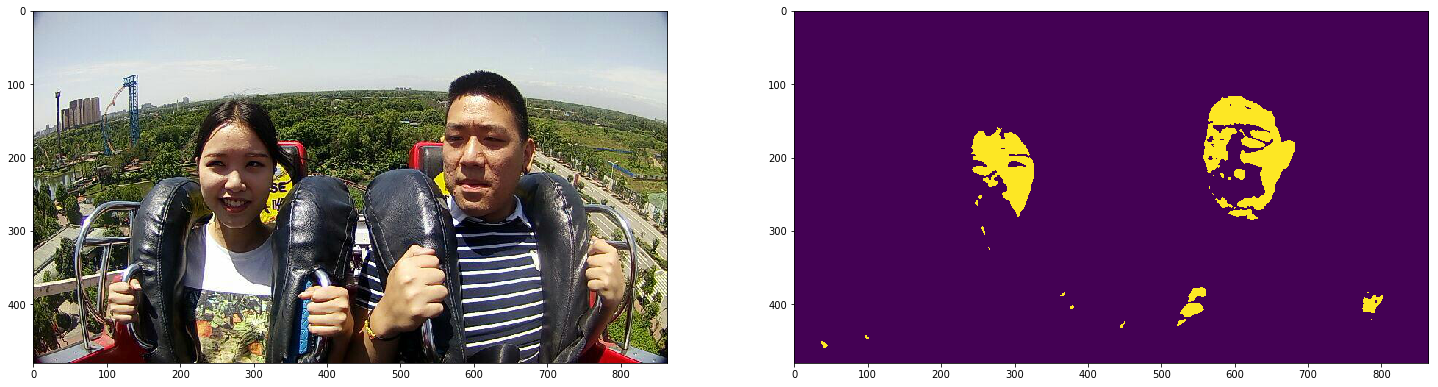

In [48]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

def skin_segment(model,image):
  image=image.astype(float)/255
  #扩展宽高到16的倍数
  h_remainder=image.shape[0]%16
  w_remainder=image.shape[1]%16
  h_pad=0
  w_pad=0
  if h_remainder!=0:
    h_pad=int(16-h_remainder)
  if w_remainder!=0:
    w_pad=int(16-w_remainder)
  if h_pad!=0 or w_pad!=0:
    image=np.pad(image,((0,h_pad),(0,w_pad),(0,0)),'edge')
  image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  mask_predict=model.predict(image)
  print(np.max(mask_predict))
  mask=np.zeros_like(mask_predict,dtype=np.uint8)
  mask[mask_predict>0.5]=255
  mask=np.squeeze(mask)
  if h_pad!=0 or w_pad!=0:
    mask=mask[0:-h_pad,0:-w_pad]
  return mask

beatify_image=io.imread('/content/image/3.jpg')
model = skin_net('/content/drive/My Drive/skin_net.hdf5')
mask=skin_segment(model,beatify_image)
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.imshow(beatify_image)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

# 结论
对光照非常敏感，可能因为unet本身用于医疗图像的分割，不会有光照的影响，扩展训练数据集可能会有一定的效果，等到再研究下PSPNet,做下对比后再决定深入做哪个方向。